# Live Audio Demo

This notebook demonstrates how to:
- Record or load a short audio clip containing a spoken keyword.
- Compute MFCC features in the same way as training.
- Run inference with the trained CNN and SNN.

In [10]:
# Cell 1: Imports and paths
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

import torchaudio
import torchaudio.transforms as T
import snntorch as snn
from snntorch import surrogate

PROJECT_ROOT = Path.cwd().resolve()
MODEL_DIR = PROJECT_ROOT / "saved_models"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("MODEL_DIR exists:", MODEL_DIR.exists())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

CLASSES = ["yes", "no", "go", "stop", "down", "up"]
SAMPLE_RATE = 16000
N_MFCC = 40

PROJECT_ROOT: /Users/maddy/Desktop/PLEP/Project/CS-576-Final-Project_backup
MODEL_DIR exists: True
Using device: cpu


In [17]:
# Cell 2: Model definitions and loading
class CNN_KWS(nn.Module):
    def __init__(self, num_classes=6, flatten_dim=3840):
        super().__init__()
        self.flatten_dim = flatten_dim

        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.features(x)
        x = torch.flatten(x, 1)
        Fdim = x.shape[1]
        if Fdim > self.flatten_dim:
            x = x[:, :self.flatten_dim]
        elif Fdim < self.flatten_dim:
            pad = self.flatten_dim - Fdim
            x = F.pad(x, (0, pad))
        return self.classifier(x)

spike_grad = surrogate.fast_sigmoid()

class SNN_KWS(nn.Module):
    def __init__(self, base_cnn: CNN_KWS, num_steps: int = 50, beta: float = 0.95):
        super().__init__()
        self.num_steps = num_steps
        self.flatten_dim = base_cnn.flatten_dim

        self.features = base_cnn.features
        self.fc1 = base_cnn.classifier[0]
        self.fc2 = base_cnn.classifier[2]

        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        spk2_rec = []
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        x = x.unsqueeze(1)

        for _ in range(self.num_steps):
            cur = self.features(x)
            cur = torch.flatten(cur, 1)

            Fdim = cur.shape[1]
            if Fdim > self.flatten_dim:
                cur = cur[:, :self.flatten_dim]
            elif Fdim < self.flatten_dim:
                pad_len = self.flatten_dim - Fdim
                cur = F.pad(cur, (0, pad_len))

            cur = F.relu(self.fc1(cur))     # <-- now safe
            spk1, mem1 = self.lif1(cur, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)

        return torch.stack(spk2_rec)

In [19]:
# Cell 3: Load trained models
cnn_ckpt_path = MODEL_DIR / "baseline_cnn_kws_vfinal.pt"
snn_ckpt_path = MODEL_DIR / "snn_kws_beta0.95_T50.pt"

print("CNN checkpoint exists:", cnn_ckpt_path.exists())
print("SNN checkpoint exists:", snn_ckpt_path.exists())

# ---- Load CNN ----
# Use the same flatten_dim that your CNN was trained with
flatten_dim_ckpt = 3840

cnn_model = CNN_KWS(
    num_classes=6, 
    flatten_dim=flatten_dim_ckpt
).to(device)

cnn_state = torch.load(cnn_ckpt_path, map_location=device)
cnn_model.load_state_dict(cnn_state)
cnn_model.eval()
print("Loaded CNN.")

# ---- Load SNN (using UPDATED SNN_KWS class) ----
snn_model = SNN_KWS(
    base_cnn=cnn_model,
    num_steps=50,
    beta=0.95
).to(device)

if snn_ckpt_path.exists():
    snn_state = torch.load(snn_ckpt_path, map_location=device)
    snn_model.load_state_dict(snn_state)
    print("Loaded SNN weights from snn_kws_beta0.95_T50.pt")
else:
    print("SNN checkpoint not found; using CNN weights only.")

snn_model.eval()
print("SNN ready.")

CNN checkpoint exists: True
SNN checkpoint exists: True
Loaded CNN.
Loaded SNN weights from snn_kws_beta0.95_T50.pt
SNN ready.


In [20]:
# Cell 4: MFCC helper
mfcc_transform = T.MFCC(
    sample_rate=SAMPLE_RATE,
    n_mfcc=N_MFCC,
    melkwargs={
        "n_fft": 400,
        "hop_length": 160,
        "n_mels": 40,
        "center": False,
    },
)

def wav_to_mfcc(path: Path):
    waveform, sr = sf.read(str(path))
    waveform = torch.tensor(waveform).float().unsqueeze(0)
    if sr != SAMPLE_RATE:
        waveform = torchaudio.functional.resample(waveform, sr, SAMPLE_RATE)
    mfcc = mfcc_transform(waveform).squeeze(0)
    mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-6)
    mfcc = torch.clamp(mfcc, -2.0, 2.0)
    return waveform.squeeze(0), mfcc

In [21]:
# Cell 5: Optional live recording using sounddevice
import importlib

have_sd = importlib.util.find_spec("sounddevice") is not None
print("sounddevice available:", have_sd)

if not have_sd:
    print("If you want live recording, install sounddevice:")
    print("  pip install sounddevice")

sounddevice available: True


In [15]:
# Cell 6: Manual Start/Stop Audio Recording
import time
import sounddevice as sd
import soundfile as sf
import numpy as np
from pathlib import Path as _Path

def record_audio_manual(fs=SAMPLE_RATE, out_path="live_record.wav"):
    """
    Manual recording: 
    - Press Enter to start
    - Press Enter again to stop
    """
    input("Press ENTER to start recording...")
    print("Recording... Press ENTER again to stop.")

    sd.default.samplerate = fs
    sd.default.channels = 1

    frames = []

    # Callback that stores microphone audio frames
    def callback(indata, frames_count, time_info, status):
        frames.append(indata.copy())

    # Open audio stream
    with sd.InputStream(callback=callback):
        input()  # Wait until user hits ENTER again to stop

    print("Stopping recording...")
    audio = np.concatenate(frames, axis=0)

    sf.write(out_path, audio, fs)
    print(f"Saved recording to {out_path}")
    return _Path(out_path)


# Use manual recorder
if have_sd:
    audio_path = record_audio_manual()
else:
    raise RuntimeError("sounddevice is not installed; use Option B instead.")

Press ENTER to start recording... 


Recording... Press ENTER again to stop.


Stopping recording...
Saved recording to live_record.wav


CNN prediction: go
SNN prediction: go


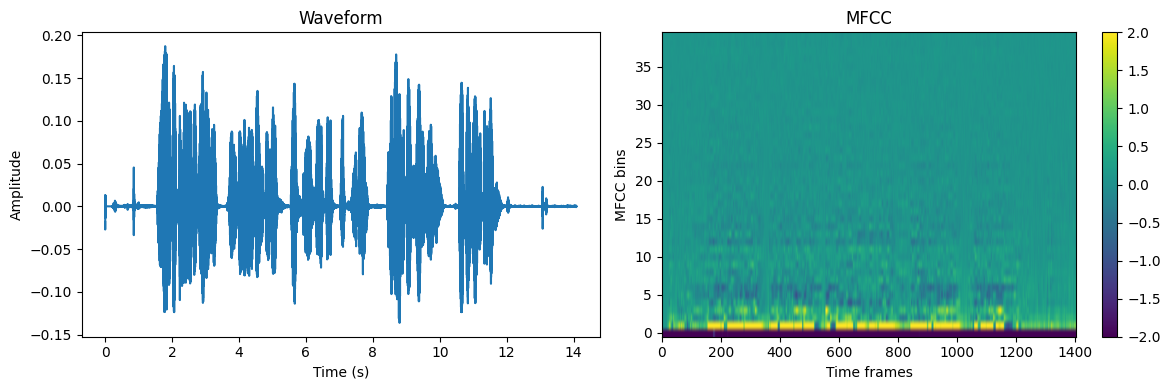

In [22]:
# Cell 7: Run inference and visualize
if not audio_path.exists():
    raise FileNotFoundError(
        f"{audio_path} does not exist. Either record with sounddevice or place a file with this name."
    )

waveform, mfcc = wav_to_mfcc(audio_path)
mfcc_batch = mfcc.unsqueeze(0).to(device)

with torch.no_grad():
    logits_cnn = cnn_model(mfcc_batch)
    pred_cnn = logits_cnn.argmax(dim=1).item()

    out_TBC = snn_model(mfcc_batch)
    logits_snn = out_TBC.sum(dim=0).squeeze(0)
    pred_snn = logits_snn.argmax().item()

print("CNN prediction:", CLASSES[pred_cnn])
print("SNN prediction:", CLASSES[pred_snn])

duration = len(waveform) / SAMPLE_RATE
t = np.linspace(0, duration, len(waveform))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(t, waveform.numpy())
axes[0].set_title("Waveform")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Amplitude")

im = axes[1].imshow(mfcc.numpy(), aspect="auto", origin="lower")
axes[1].set_title("MFCC")
axes[1].set_xlabel("Time frames")
axes[1].set_ylabel("MFCC bins")
fig.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()